# Classificator for next Streams 

# <span style='background :khaki' > Install & Importa Libraries </span>

In [1]:
### ***Enviroment Preparation***
# Install Pandas
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install lightgbm

!pip install dtale

!pip install sktime
!pip install sklego

#!pip install skforecast

# Update pip -- WARNING Resolution
!python.exe -m pip install --upgrade pip

In [2]:
### ***Imports***
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import dtale

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime
from datetime import timedelta

from statsmodels.tsa.stattools import adfuller, kpss

from sklego.preprocessing import RepeatingBasisFunction

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

import time
# Current Location.. !cd
#C:\Users\ghoyo\Desktop\TFM\Nuevo\Proyect

# Paths
data_one_hot = r"C:\Users\ghoyo\Desktop\TFM4\Project\GeneratedDfs\one_hot.json"
data_labeled = r"C:\Users\ghoyo\Desktop\TFM4\Project\GeneratedDfs\labeled.json"
selenium_features = r"C:\Users\ghoyo\Desktop\TFM4\Project\GeneratedDfs\popularity.json"
data_features = r"C:\Users\ghoyo\Desktop\TFM4\Project\GeneratedDfs\df&popularity.json"

### <span style='background :lightgreen' > Some Analysis </span>

#### <span style='background :skyblue' > One Hot DF </span>

In [3]:
df_one_hot = pd.read_json(data_one_hot)
df_selenium = pd.read_json(selenium_features)
df_one_hot.shape

(72, 113)

In [4]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2022-11-21 07:31:24 to 2022-11-24 22:27:00
Columns: 113 entries, is_song to reason_end_trackdone
dtypes: int64(113)
memory usage: 64.1 KB


In [5]:
df_one_hot.describe().T

,count,mean,std,min,25%,50%,75%,max
is_song,72.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
is_podcast,72.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
s_played,72.0,197.569444,87.326460,17.0,131.5,199.5,272.0,354.0
df_fractured,72.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
platform_Phone,72.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
reason_start_trackdone,72.0,0.666667,0.474713,0.0,0.0,1.0,1.0,1.0
reason_end_endplay,72.0,0.069444,0.255992,0.0,0.0,0.0,0.0,1.0
reason_end_fwdbtn,72.0,0.041667,0.201229,0.0,0.0,0.0,0.0,1.0
reason_end_logout,72.0,0.097222,0.298339,0.0,0.0,0.0,0.0,1.0


In [6]:
df_one_hot.head(2)

,is_song,is_podcast,s_played,df_fractured,platform_Phone,master_metadata_track_name_58500,master_metadata_track_name_58500 - Daniel Avery Remix,master_metadata_track_name_BB,master_metadata_track_name_Be Good,master_metadata_track_name_Beautiful,...,master_metadata_album_album_name_je suis,master_metadata_album_album_name_mwah :3,reason_start_clickrow,reason_start_fwdbtn,reason_start_playbtn,reason_start_trackdone,reason_end_endplay,reason_end_fwdbtn,reason_end_logout,reason_end_trackdone
2022-11-21 07:31:24,1,0,17,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2022-11-21 07:36:41,1,0,296,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [7]:
col = df_one_hot.columns[df_one_hot.columns.str.contains('master_metadata_track_name')]
len(col)
print(df_one_hot[col])

                     master_metadata_track_name_58500  \
2022-11-21 07:31:24                                 0   
2022-11-21 07:36:41                                 0   
2022-11-21 17:14:59                                 0   
2022-11-21 17:20:25                                 0   
2022-11-21 18:03:37                                 0   
...                                               ...   
2022-11-24 22:13:20                                 0   
2022-11-24 22:15:38                                 0   
2022-11-24 22:20:21                                 0   
2022-11-24 22:22:38                                 0   
2022-11-24 22:27:00                                 0   

                     master_metadata_track_name_58500 - Daniel Avery Remix  \
2022-11-21 07:31:24                                                  0       
2022-11-21 07:36:41                                                  0       
2022-11-21 17:14:59                                                  0       
202

#### <span style='background :skyblue' > Labeled DF </span>

In [8]:
df_labeled = pd.read_json(data_labeled)
df_labeled.shape

(72, 10)

In [9]:
df_labeled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2022-11-21 07:31:24 to 2022-11-24 22:27:00
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   is_song                                  72 non-null     int64
 1   is_podcast                               72 non-null     int64
 2   s_played                                 72 non-null     int64
 3   df_fractured                             72 non-null     int64
 4   platform_label                           72 non-null     int64
 5   master_metadata_track_name_label         72 non-null     int64
 6   master_metadata_album_artist_name_label  72 non-null     int64
 7   master_metadata_album_album_name_label   72 non-null     int64
 8   reason_start_label                       72 non-null     int64
 9   reason_end_label                         72 non-null     int64
dtypes: int64(10)
memory usage: 6.2 KB


In [10]:
df_labeled.describe().T

,count,mean,std,min,25%,50%,75%,max
is_song,72.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
is_podcast,72.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
s_played,72.0,197.569444,87.326460,17.0,131.50,199.5,272.00,354.0
df_fractured,72.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
platform_label,72.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
master_metadata_track_name_label,72.0,17.569444,11.164363,0.0,7.75,18.5,27.25,36.0
master_metadata_album_artist_name_label,72.0,11.916667,7.450777,0.0,7.00,8.0,19.00,26.0
master_metadata_album_album_name_label,72.0,18.180556,11.350158,0.0,7.00,19.5,28.00,35.0
reason_start_label,72.0,2.222222,1.201199,0.0,1.00,3.0,3.00,3.0
reason_end_label,72.0,2.611111,0.864895,0.0,3.00,3.0,3.00,3.0


In [11]:
df_labeled.head(2)

,is_song,is_podcast,s_played,df_fractured,platform_label,master_metadata_track_name_label,master_metadata_album_artist_name_label,master_metadata_album_album_name_label,reason_start_label,reason_end_label
2022-11-21 07:31:24,1,0,17,0,0,33,6,13,3,2
2022-11-21 07:36:41,1,0,296,0,0,6,2,7,0,3


In [12]:
len(df_labeled['master_metadata_track_name_label'].unique())

37

#### <span style='background :violet' > Functions </span>

In [13]:
import re
import pandas as pd

def remove_special_characters(df):
    """
    Removes all special characters and replaces them with an empty string in the column names of a pandas DataFrame.
    """
    # Define a regex pattern to match all non-alphanumeric characters
    pattern = re.compile(r'[^a-zA-Z0-9_]+')
    
    # Replace all special characters with an empty string in each column name
    new_columns = [pattern.sub('', col) for col in df.columns]
    
    # Rename the columns of the DataFrame with the new names
    df.columns = new_columns
    
    return df

In [14]:
def select_cols_with_string(df, string):
    """
    Select all columns in a Pandas DataFrame that contain a specific string in their column name.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to select columns from.
    string : str
        String to search for in column names.
    
    Returns
    -------
    pandas.DataFrame
        DataFrame with selected columns.
    """
    selected_cols = df.filter(like=string).columns
    
    return df[selected_cols]

In [15]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, numb):
        self.n_splits = n_splits
        self.numb = numb
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = stop-self.numb
            yield indices[start: mid], indices[mid + margin: stop]

In [16]:
# persistence model
def model_persistence(x):
    return x

# <span style='background :khaki' > Predictions  </span>

#### <span style="background:skyblue"> Global Variables <span>

In [17]:
n_songs = 17
n_sims = 75

### <span style='background :lightgreen' > Variable Importance Tree

#### <span style="background:skyblue"> One Hot <span>

In [18]:
df_one_hot = remove_special_characters(df_one_hot)

In [19]:
# Seleccionar columnas con "income" en su nombre
Y_one_hot = select_cols_with_string(df_one_hot, "master_metadata_track_name_")

# Mostrar DataFrame seleccionado
#print(Y)

In [20]:
# Split data
X_one_hot = df_one_hot.drop(Y_one_hot, axis=1)
y_one_hot = Y_one_hot

In [21]:
# We gess the prediction of n_streams = 29, and n_new streams = 14, so we want to predict only 15 values to the future
forecast_num = 15

# Split data for train and test
X_train_one_hot = X_one_hot[:-forecast_num]
X_test_one_hot = X_one_hot[-forecast_num:]
y_train_one_hot = y_one_hot[:-forecast_num]
y_test_one_hot = y_one_hot[-forecast_num:]

1. feature 2 (0.167027)
2. feature 34 (0.044831)
3. feature 64 (0.042057)
4. feature 24 (0.036403)
5. feature 37 (0.035308)
6. feature 13 (0.033646)
7. feature 21 (0.027169)
8. feature 12 (0.026247)
9. feature 68 (0.026002)
10. feature 71 (0.024719)
11. feature 57 (0.023748)
12. feature 11 (0.021273)
13. feature 45 (0.020384)
14. feature 67 (0.018709)
15. feature 25 (0.017361)
16. feature 10 (0.017221)
17. feature 7 (0.016539)
18. feature 46 (0.016413)
19. feature 60 (0.016085)
20. feature 9 (0.015747)
21. feature 33 (0.015741)
22. feature 69 (0.015602)
23. feature 43 (0.015442)
24. feature 55 (0.015261)
25. feature 75 (0.014494)
26. feature 30 (0.014067)
27. feature 31 (0.013659)
28. feature 59 (0.013297)
29. feature 39 (0.011984)
30. feature 72 (0.011665)
31. feature 5 (0.011430)
32. feature 54 (0.011312)
33. feature 74 (0.011294)
34. feature 48 (0.011293)
35. feature 32 (0.010769)
36. feature 63 (0.010666)
37. feature 40 (0.010265)
38. feature 41 (0.010262)
39. feature 42 (0.008923)

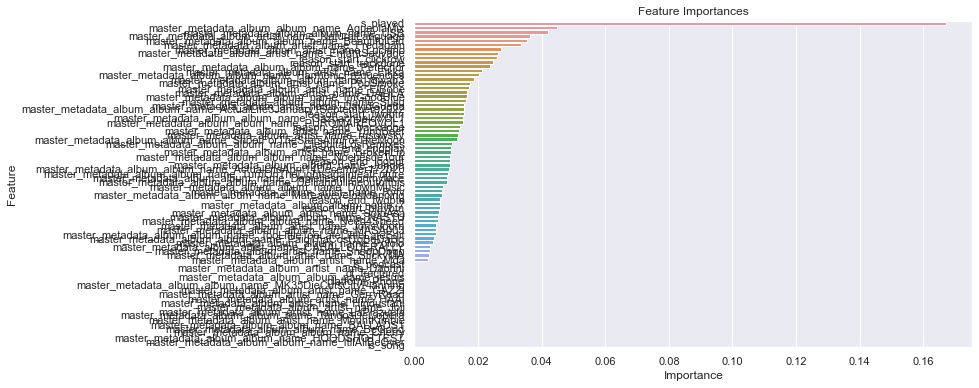

In [22]:
# Fit the Random Forest Classifier to the training data
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_one_hot, y_train_one_hot)

# Make predictions on the test set
y_pred = clf.predict(X_test_one_hot)

# Get the feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature importances
for f in range(X_train_one_hot.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances using seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_train_one_hot.columns[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### <span style="background:skyblue"> Labeled <span>

In [23]:
df_labeled = remove_special_characters(df_labeled)

In [24]:
# Seleccionar columnas con "income" en su nombre
Y_labeled = select_cols_with_string(df_labeled, "master_metadata_track_name_")

# Mostrar DataFrame seleccionado
#print(Y)

In [25]:
# Split data
X_labeled = df_labeled.drop(Y_labeled, axis=1)
y_labeled = Y_labeled

In [26]:
# We gess the prediction of n_streams = 29, and n_new streams = 14, so we want to predict only 15 values to the future
forecast_num = 15

# Split data for train and test
X_train_labeled = X_labeled[:-forecast_num]
X_test_labeled = X_labeled[-forecast_num:]
y_train_labeled = y_labeled[:-forecast_num]
y_test_labeled = y_labeled[-forecast_num:]

1. feature 6 (0.307966)
2. feature 2 (0.292320)
3. feature 5 (0.254908)
4. feature 7 (0.086737)
5. feature 8 (0.058069)
6. feature 4 (0.000000)
7. feature 3 (0.000000)
8. feature 1 (0.000000)
9. feature 0 (0.000000)


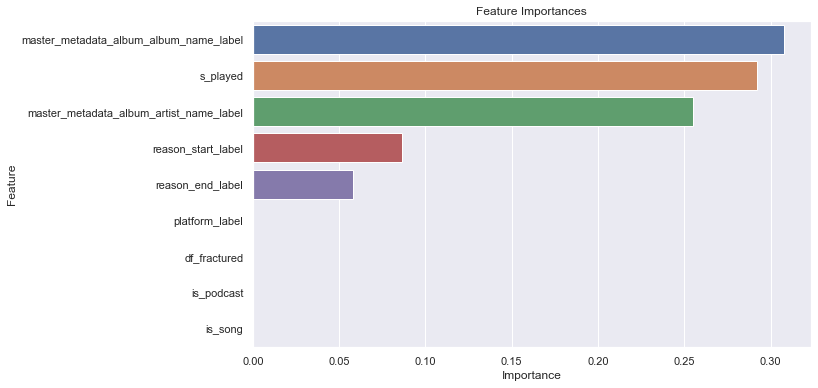

In [27]:
# Fit the Random Forest Classifier to the training data
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_labeled, y_train_labeled)

# Make predictions on the test set
y_pred_labeled = clf.predict(X_test_labeled)

# Get the feature importances
importances = clf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature importances
for f in range(X_train_labeled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances using seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_train_labeled.columns[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## <span style='background :lightgreen' > Baseline </span>

### <span style="background:skyblue"> One Hot <span>

<span style="background:skyblue"> 1 Lag, dummy regresor <span>

In [28]:
# Create Base Lag
df_base_one_hot = df_one_hot.copy()
n_lags = 1

for i in Y_one_hot.columns:
    df_base_one_hot[i + '_lag_'+ str(1)] = df_base_one_hot[i].shift(1)

df_base_one_hot.dropna(inplace=True)
df_base_one_hot.reset_index(inplace=True, drop=True)
df_base_one_hot.tail(7)

,is_song,is_podcast,s_played,df_fractured,platform_Phone,master_metadata_track_name_58500,master_metadata_track_name_58500DanielAveryRemix,master_metadata_track_name_BB,master_metadata_track_name_BeGood,master_metadata_track_name_Beautiful,...,master_metadata_track_name_RomnceMsoc_lag_1,master_metadata_track_name_Susu_lag_1,master_metadata_track_name_TangosDeCopera_lag_1,master_metadata_track_name_TooLittleTooLateLittleLateEdit_lag_1,master_metadata_track_name_TurnOnTheLightsagainfeatFuture_lag_1,master_metadata_track_name_WHYAMISTILLINLAfeatShlohmoD33J_lag_1,master_metadata_track_name_escapism_lag_1,master_metadata_track_name_jesuis_lag_1,master_metadata_track_name_mwah3_lag_1,master_metadata_track_name_somehowshesstillherefeatJamesBlake_lag_1
64,1,0,272,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,1,0,146,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66,1,0,122,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,1,0,28,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68,1,0,272,0,1,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,1,0,122,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
70,1,0,268,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
# X DATA... 
cols = df_base_one_hot.columns[df_base_one_hot.columns.str.contains('lag')]
X = df_base_one_hot[cols].squeeze()

# Y DATA SPLIT
y = df_base_one_hot[Y_one_hot.columns]
print(y.columns)
# Other Variables
test_size = forecast_num

# Train, Predict and error.
predict = []
for x in list(X.columns):
    pre = []
    for xx in X[x][-test_size:]:
        yhat = model_persistence(xx)
        pre.append(yhat)
    predict.append(pre)
    print('pre', pre)

# Prepare Real data (Y) From Dataframe to be computed by acc Score
real = []
for yy in list(y.columns):
    r = []
    for yyy in y[yy][-test_size:]:
        r.append(yyy)
    real.append(r)
    print('r', r)

print('predict', predict)
print('real', real)

acc = accuracy_score(real, predict)
print(acc)

Index(['master_metadata_track_name_58500',
       'master_metadata_track_name_58500DanielAveryRemix',
       'master_metadata_track_name_BB', 'master_metadata_track_name_BeGood',
       'master_metadata_track_name_Beautiful',
       'master_metadata_track_name_BeautifulGirl',
       'master_metadata_track_name_Cieguita',
       'master_metadata_track_name_CieguitaGAZZIRemix',
       'master_metadata_track_name_Clarathenightisdark',
       'master_metadata_track_name_Daniellesmileonmyface',
       'master_metadata_track_name_Delilahpullmeoutofthis',
       'master_metadata_track_name_DiceftMCBuzzzChicheNieto',
       'master_metadata_track_name_Falling',
       'master_metadata_track_name_HOODSHOTTEST',
       'master_metadata_track_name_ImGoodBlue',
       'master_metadata_track_name_ImperfectionsInterlude',
       'master_metadata_track_name_ItllAllBeOverDJKozeRemixRadioEdit',
       'master_metadata_track_name_JhayCortezTokyoBrokenLipEDIT',
       'master_metadata_track_name_Jungle',

The rows that sum up this acc score are those with indices 0, 1, 3, 12, 13, and 17. These are the rows that have all zeros except for a single 1 in the true labels.

#### <span style="background:red"> This is interesting. There are rows that are all 0s, because they havent been listened on the last days of the weekend, thats why it scores so high. This leave us with 2 options left: <span>
    - We can reduce the dataset to exactly the days we take into account to predict (even less data)
    - We change our way of thinking and predict which songs will probably not be listened from the ones listened las week, this may make possible even to increase the dataset (problem of dimesionality)

#### <span style="background:skyblue"> CV <span>

<span style="background:skyblue"> TSCV <span>

In [30]:
# X DATA... 
cols = df_base_one_hot.columns[df_base_one_hot.columns.str.contains('lag')]
X_one_hot = df_base_one_hot[cols].squeeze()
# Y DATA SPLIT
y_one_hot = df_base_one_hot[Y_one_hot.columns]

# Other Variables
test_size = forecast_num
predict = []
acc = []
#Split, Train, Predict and error.

tscv = TimeSeriesSplit(max_train_size=None, n_splits = 4, test_size=test_size)

for train_index, test_index in tscv.split(X):
    predict = []
    #print('TRAIN:', train_index, 'TEST:', test_index) 
    X_train_one_hot, X_test_one_hot = X_one_hot.loc[train_index], X_one_hot.loc[test_index]
    y_train_one_hot, y_test_one_hot = y_one_hot.loc[train_index], y_one_hot.loc[test_index]
        
    predict = []
    for x in list(X.columns):
        pre = []
        for xx in X_test_one_hot[x][-test_size:]:
            yhat = model_persistence(xx)
            pre.append(yhat)
        predict.append(pre)
    
    # Prepare real data to be computed
    real = []
    for yy in list(y.columns):
        r = []
        for yyy in y_test_one_hot[yy][-test_size:]:
            r.append(yyy)
        real.append(r)
            
    #print('Prediction = ', predict, ' -- Vs -- ', 'Original = ', list(y_test[-test_size:]))
    acc.append(accuracy_score(real, predict))
    #print('ACC = ', acc[-1])
    
print('ACC Mean = ', np.mean(acc))
print('\n')


ACC Mean =  0.6081081081081081




<span style="background:skyblue"> BCV <span>

In [31]:
# X DATA... 
cols = df_base_one_hot.columns[df_base_one_hot.columns.str.contains('lag')]
X_one_hot = df_base_one_hot[cols].squeeze()
# Y DATA SPLIT
y_one_hot = df_base_one_hot[Y_one_hot.columns]

# Other Variables
test_size = forecast_num
predict = []
acc = []
#Split, Train, Predict and error.

tscv = BlockingTimeSeriesSplit(n_splits = 4, numb = test_size)
for train_index, test_index in tscv.split(X):
    predict = []
    #print('TRAIN:', train_index, 'TEST:', test_index) 
    X_train_one_hot, X_test_one_hot = X_one_hot.loc[train_index], X_one_hot.loc[test_index]
    y_train_one_hot, y_test_one_hot = y_one_hot.loc[train_index], y_one_hot.loc[test_index]

    predict = []
    for x in list(X.columns):
        pre = []
        for xx in X_test_one_hot[x][-test_size:]:
            yhat = model_persistence(xx)
            pre.append(yhat)
        predict.append(pre)
    
    # Prepare real data to be computed
    real = []
    for yy in list(y.columns):
        r = []
        for yyy in y_test_one_hot[yy][-test_size:]:
            r.append(yyy)
        real.append(r)
        
    #print('Prediction = ', predict, ' -- Vs -- ', 'Original = ', list(y_test[-test_size:]))
    acc.append(accuracy_score(real, predict))
    #print('ACC = ', acc[-1])
    
print('ACC Mean = ', np.mean(acc))
print('\n')


ACC Mean =  0.6283783783783784




### <span style="background:skyblue"> Labeled <span>

<span style="background:skyblue"> 1 Lag, dummy regresor <span>

In [32]:
# Create Base Lag

df_base_labeled = df_labeled.copy()
n_lags = 1

for i in range(n_lags):
    df_base_labeled['lag_'+ str(i+1)] = df_base_labeled['master_metadata_track_name_label'].shift(i+1)

df_base_labeled.dropna(inplace=True)
df_base_labeled.reset_index(inplace=True, drop=True)
df_base_labeled.tail(7)

,is_song,is_podcast,s_played,df_fractured,platform_label,master_metadata_track_name_label,master_metadata_album_artist_name_label,master_metadata_album_album_name_label,reason_start_label,reason_end_label,lag_1
64,1,0,272,0,0,34,9,34,2,3,3.0
65,1,0,146,0,0,17,0,11,2,3,34.0
66,1,0,122,0,0,35,26,35,3,3,17.0
67,1,0,28,0,0,29,15,29,3,0,35.0
68,1,0,272,0,0,34,9,34,0,3,29.0
69,1,0,122,0,0,35,26,35,0,3,34.0
70,1,0,268,0,0,29,15,29,3,3,35.0


In [33]:
# X DATA... 
cols = df_base_labeled.columns[df_base_labeled.columns.str.contains('lag')]
X = df_base_labeled[cols].squeeze()

# Y DATA SPLIT
y = df_base_labeled[Y_labeled.columns]

# Other Variables
test_size = forecast_num

# Train, Predict and error.
predict = []
for x in X[-test_size:]:
    yhat = model_persistence(x)
    predict.append(yhat)
    
print(predict)
print(y[-test_size:])
acc = accuracy_score(y[-test_size:], predict)
print(acc)

[5.0, 0.0, 13.0, 12.0, 1.0, 16.0, 36.0, 32.0, 3.0, 34.0, 17.0, 35.0, 29.0, 34.0, 35.0]
    master_metadata_track_name_label
56                                 0
57                                13
58                                12
59                                 1
60                                16
61                                36
62                                32
63                                 3
64                                34
65                                17
66                                35
67                                29
68                                34
69                                35
70                                29
0.0


#### <span style="background:skyblue"> CV <span>

<span style="background:skyblue"> TSCV <span>

In [34]:
# X DATA... 
cols = df_base_labeled.columns[df_base_labeled.columns.str.contains('lag')]
X_labeled = df_base_labeled[cols].squeeze()
# Y DATA SPLIT
y_labeled = df_base_labeled[Y_labeled.columns]

# Other Variables
test_size = forecast_num
predict = []
acc = []
#Split, Train, Predict and error.

tscv = TimeSeriesSplit(max_train_size=None, n_splits = 4, test_size=test_size)

for train_index, test_index in tscv.split(X):
    predict = []
    #print('TRAIN:', train_index, 'TEST:', test_index) 
    X_train_labeled, X_test_labeled = X_labeled.loc[train_index], X_labeled.loc[test_index]
    y_train_labeled, y_test_labeled = y_labeled.loc[train_index], y_labeled.loc[test_index]
        
    predict = []
    for x in X_test_labeled[-test_size:]:
        yhat = model_persistence(x)
        predict.append(yhat)
            
    #print('Prediction = ', predict, ' -- Vs -- ', 'Original = ', list(y_test[-test_size:]))
    acc.append(accuracy_score(y[-test_size:], predict))
    #print('ACC = ', acc[-1])
    
print('ACC Mean = ', np.mean(acc))

ACC Mean =  0.0


<span style="background:skyblue"> BCV <span>

In [35]:
# X DATA... 
cols = df_base_labeled.columns[df_base_labeled.columns.str.contains('lag')]
X_labeled = df_base_labeled[cols].squeeze()
# Y DATA SPLIT
y_labeled = df_base_labeled[Y_labeled.columns]

# Other Variables
test_size = forecast_num
predict = []
acc = []
#Split, Train, Predict and error.

tscv = BlockingTimeSeriesSplit(n_splits = 4, numb = test_size)
for train_index, test_index in tscv.split(X):
    predict = []
    #print('TRAIN:', train_index, 'TEST:', test_index) 
    X_train_labeled, X_test_labeled = X_labeled.loc[train_index], X_labeled.loc[test_index]
    y_train_labeled, y_test_labeled = y_labeled.loc[train_index], y_labeled.loc[test_index]

    predict = []
    for x in X_test_labeled[-test_size:]:
        yhat = model_persistence(x)
        predict.append(yhat)
            
    #print('Prediction = ', predict, ' -- Vs -- ', 'Original = ', list(y_test[-test_size:]))
    acc.append(accuracy_score(y[-test_size:], predict))
    #print('ACC = ', acc[-1])
    
print('ACC Mean = ', np.mean(acc))

ACC Mean =  0.016666666666666666
